In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import datetime

In [3]:
target = pd.read_csv('dengue_labels_train.csv')
data = pd.read_csv('dengue_features_train.csv')
validate = pd.read_csv('dengue_features_test.csv')

In [4]:
def date_convert(data):
    data['date'] = 0
    predate = str(data.loc[0, 'year']) + "-W" + str(data.loc[0, 'weekofyear'])
    data.loc[0, 'date'] = datetime.datetime.strptime(predate + '-1', "%Y-W%W-%w")
    for i in range(data.shape[0] - 1):
        data.loc[i+1, 'date'] = data.loc[i, 'date'] + datetime.timedelta(days =7)
        
def date_convert2(data):
    data['date'] = 0
    for i in range(data.shape[0]):
        data.loc[i,'date'] = datetime.datetime.strptime(data.loc[i,'week_start_date'],
                                                        '%Y-%m-%d')

In [5]:
date_convert2(data)
date_convert2(validate)

In [6]:
sj_data = data.loc[data.city == 'sj']
iq_data = data.loc[data.city == 'iq']
sj_y_train = target.loc[target.city == 'sj'].total_cases
iq_y_train = target.loc[target.city == 'iq'].total_cases
sj_data['total_cases'] = sj_y_train
iq_data['total_cases'] = iq_y_train
iq_data = iq_data.reset_index().drop('index', axis = 1)

sj_valid = validate.loc[validate.city == 'sj']
iq_valid = validate.loc[validate.city == 'iq']

In [7]:
sj_data = sj_data.drop(['city', 'year', 
                        'weekofyear', 'week_start_date'], axis = 1).set_index('date')
iq_data = iq_data.drop(['city', 'year', 
                      'weekofyear', 'week_start_date'], axis = 1).set_index('date')
sj_valid = sj_valid.drop(['city', 'year', 
                        'weekofyear', 'week_start_date'], axis = 1).set_index('date')
iq_valid = iq_valid.drop(['city', 'year', 
                      'weekofyear', 'week_start_date'], axis = 1).set_index('date')

In [8]:
sj_valid['total_cases'] = np.nan
iq_valid['total_cases'] = np.nan

In [9]:
sj_all = pd.DataFrame(np.vstack([sj_data, sj_valid]))
sj_all.columns = sj_data.columns

iq_all = pd.DataFrame(np.vstack([iq_data, iq_valid]))
iq_all.columns = iq_data.columns

In [10]:
sj_all.isnull().sum()

ndvi_ne                                  234
ndvi_nw                                   60
ndvi_se                                   20
ndvi_sw                                   20
precipitation_amt_mm                      11
reanalysis_air_temp_k                      8
reanalysis_avg_temp_k                      8
reanalysis_dew_point_temp_k                8
reanalysis_max_air_temp_k                  8
reanalysis_min_air_temp_k                  8
reanalysis_precip_amt_kg_per_m2            8
reanalysis_relative_humidity_percent       8
reanalysis_sat_precip_amt_mm              11
reanalysis_specific_humidity_g_per_kg      8
reanalysis_tdtr_k                          8
station_avg_temp_c                         8
station_diur_temp_rng_c                    8
station_max_temp_c                         8
station_min_temp_c                         8
station_precip_mm                          8
total_cases                              260
dtype: int64

In [11]:
iq_all.isnull().sum()

ndvi_ne                                    3
ndvi_nw                                    3
ndvi_se                                    3
ndvi_sw                                    3
precipitation_amt_mm                       4
reanalysis_air_temp_k                      4
reanalysis_avg_temp_k                      4
reanalysis_dew_point_temp_k                4
reanalysis_max_air_temp_k                  4
reanalysis_min_air_temp_k                  4
reanalysis_precip_amt_kg_per_m2            4
reanalysis_relative_humidity_percent       4
reanalysis_sat_precip_amt_mm               4
reanalysis_specific_humidity_g_per_kg      4
reanalysis_tdtr_k                          4
station_avg_temp_c                        47
station_diur_temp_rng_c                   47
station_max_temp_c                        15
station_min_temp_c                        15
station_precip_mm                         19
total_cases                              156
dtype: int64

For San Juan, let's test the correlations between total_cases and all ndvi data. Since the ndvi data contain a lot of missing values, I will neglect them if they do not have any sign of correlation with the total_cases variable.

In [12]:
ndvi = sj_data[['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw']]
series = target[target.city == 'sj'].total_cases
ndvi['total_cases'] = series.values

In [13]:
ndvi = ndvi.dropna(axis = 0)

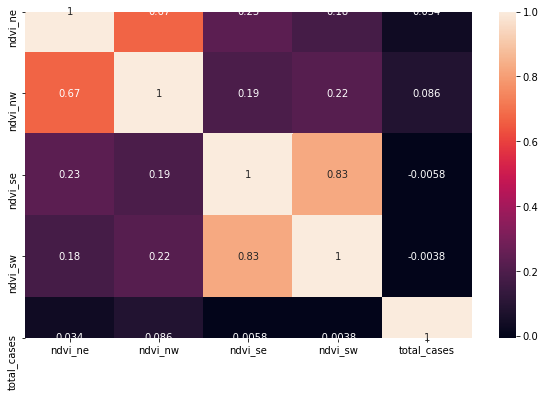

In [14]:
# Correlation Test
import seaborn as sns
plt.figure(figsize = (10,6))
ndvi_corr = ndvi.corr()
sns.heatmap(ndvi_corr, annot = True)
plt.show()

In [15]:
ndvi_corr

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,total_cases
ndvi_ne,1.000000,0.673037,0.231922,0.176511,0.034179
ndvi_nw,0.673037,1.000000,0.192755,0.219379,0.085682
ndvi_se,0.231922,0.192755,1.000000,0.827828,-0.005817
ndvi_sw,0.176511,0.219379,0.827828,1.000000,-0.003785
total_cases,0.034179,0.085682,-0.005817,-0.003785,1.000000


The correlation coefficients between total_cases and every ndvi variable is very little, so let's drop those features for now.

For Iquitos, check correlation between total_cases and station data.

In [16]:
iq_station = iq_data[[col for col in iq_all.columns if col[:4] == 'stat']]
iq_station['total_cases'] = target[target.city == 'iq'].total_cases.values

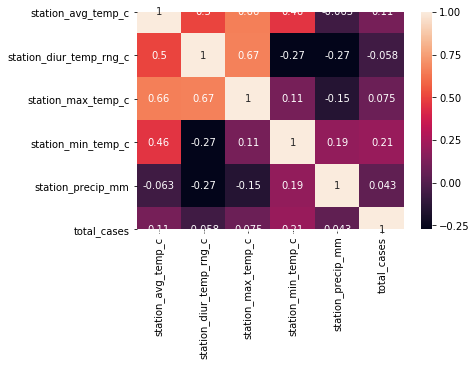

In [17]:
corr_iqstation = iq_station.corr()
sns.heatmap(corr_iqstation, annot = True)

In [18]:
corr_iqstation

,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
station_avg_temp_c,1.000000,0.503965,0.658591,0.460419,-0.062609,0.113070
station_diur_temp_rng_c,0.503965,1.000000,0.665672,-0.273421,-0.270896,-0.058230
station_max_temp_c,0.658591,0.665672,1.000000,0.111946,-0.148968,0.075279
station_min_temp_c,0.460419,-0.273421,0.111946,1.000000,0.191378,0.211702
station_precip_mm,-0.062609,-0.270896,-0.148968,0.191378,1.000000,0.042976
total_cases,0.113070,-0.058230,0.075279,0.211702,0.042976,1.000000


<Figure size 1440x1152 with 0 Axes>

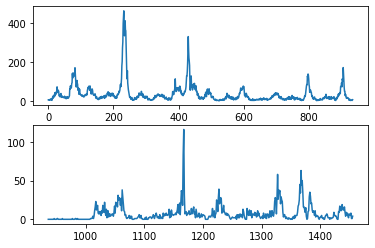

In [19]:
# Line Plot
plt.figure(figsize = (20,16))
fig, ax = plt.subplots(2,1, sharey=False)
ax[0].plot(sj_y_train)
ax[1].plot(iq_y_train)
plt.show()

In [20]:
sj_date = np.hstack([sj_data.index, sj_valid.index])
iq_date = np.hstack([iq_data.index, iq_valid.index])

sj_all.index = sj_date
iq_all.index = iq_date

sj_y_train.index = sj_data.index
iq_y_train.index = iq_data.index

In [21]:
sj_all.head()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4.0
1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5.0
1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4.0
1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3.0
1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6.0


In [27]:
# Save it first
sj_y_train.to_csv('SanJuan_label.csv', index = True)
iq_y_train.to_csv('Iquitos_label.csv', index = True)

sj_all.to_excel('SanJuan_all.xlsx', index = True)
iq_all.to_excel('Iquitos_all.xlsx', index = True)

# Data Preprocessing - Missing Value Manipulation

In [22]:
sj_all.index.month.unique()

Int64Index([4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3], dtype='int64')

In [23]:
# San Juan
sj_month_mean = dict()
print('Average Number per month in San Juan: ')
for month in range(1,13):
    print('Month #%s = %.4f' % (month, np.mean(sj_y_train[sj_y_train.index.month == month])))
    sj_month_mean[month] = np.mean(sj_y_train[sj_y_train.index.month == month])

Average Number per month in San Juan: 
Month #1 = 31.4222
Month #2 = 21.0972
Month #3 = 14.5972
Month #4 = 10.0222
Month #5 = 11.1389
Month #6 = 16.3194
Month #7 = 27.3556
Month #8 = 48.0417
Month #9 = 55.7500
Month #10 = 71.0000
Month #11 = 61.8194
Month #12 = 41.6806


In [24]:
# Iquitos
iq_month_mean = dict()
print('Average Number per month in Iquitos:')
for month in range(1,13):
    print('Month #%s = %.4f' % (month, np.mean(iq_y_train[iq_y_train.index.month == month])))
    iq_month_mean[month] = np.mean(iq_y_train[iq_y_train.index.month == month])

Average Number per month in Iquitos:
Month #1 = 12.0800
Month #2 = 12.5750
Month #3 = 7.2500
Month #4 = 5.7000
Month #5 = 4.8500
Month #6 = 3.3750
Month #7 = 3.0600
Month #8 = 3.1500
Month #9 = 6.4419
Month #10 = 9.7447
Month #11 = 9.8250
Month #12 = 12.9000


In [25]:
# Approach #1: Replace null with monthwise mean.
def mean_replace(data):
    for col in data.columns:
        if data[col].isnull().any():
            data[col] = data[col].fillna(np.mean(data[col]))
    return data

In [26]:
sj_all2 = sj_all.copy().drop(['total_cases'], axis = 1)

In [27]:
sj_all2 = mean_replace(sj_all2)

In [28]:
iq_all2 = iq_all.copy().drop(['total_cases'], axis = 1)
iq_all2 = mean_replace(iq_all2)

# The First Neural Network

In [29]:
# Try 1st NN with lag-2, note that SanJuan has 936 training observations, whereas Iquitos has
# 520.
sj_train = sj_all2.iloc[:934]
sj_label = sj_y_train[2:].reset_index(drop = True)
sj_test = sj_all2.iloc[934:-2]

iq_train = iq_all2.iloc[:518]
iq_label = iq_y_train[2:].reset_index(drop = True)
iq_test = iq_all2.iloc[518:-2]

In [30]:
# Load submission
subm = pd.read_csv('submission_format.csv')

In [31]:
subm.shape

(416, 4)

In [32]:
sj_test.shape[0] + iq_test.shape[0]

416

In [71]:
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers

In [96]:
model1 = Sequential()
model1.add(Dense(units = 64, kernel_initializer = 'uniform',
                activation = 'relu', input_dim = sj_train.shape[1]))
model1.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu'))
model1.add(Dense(units = 256, kernel_initializer = 'uniform', activation = 'relu'))
model1.add(Dense(units = 512, kernel_initializer = 'uniform', activation = 'sigmoid'))
model1.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'linear'))

sgd = optimizers.SGD(lr = 0.001, decay = 1, momentum = 0.99)
model1.compile(optimizer = sgd, loss = 'mae', metrics = ['accuracy'])

In [98]:
# San Juan
model1.fit(sj_train, sj_label, epochs = 20, batch_size=2, verbose = 1)

Epoch 1/20
934/934 [==============================] - 1s 1ms/step - loss: 24.7430 - accuracy: 0.0193
Epoch 2/20
934/934 [==============================] - 1s 1ms/step - loss: 24.7432 - accuracy: 0.0193
Epoch 3/20
934/934 [==============================] - 1s 1ms/step - loss: 24.7419 - accuracy: 0.0139
Epoch 4/20
934/934 [==============================] - 1s 1ms/step - loss: 24.7410 - accuracy: 0.0150
Epoch 5/20
934/934 [==============================] - 1s 1ms/step - loss: 24.7407 - accuracy: 0.0150
Epoch 6/20
934/934 [==============================] - 1s 1ms/step - loss: 24.7410 - accuracy: 0.0150
Epoch 7/20
934/934 [==============================] - 1s 1ms/step - loss: 24.7408 - accuracy: 0.0150
Epoch 8/20
934/934 [==============================] - 1s 1ms/step - loss: 24.7397 - accuracy: 0.0150
Epoch 9/20
934/934 [==============================] - 1s 1ms/step - loss: 24.7390 - accuracy: 0.0150
Epoch 10/20
934/934 [==============================] - 1s 1ms/step - loss: 24.7385 - accura

In [101]:
model2 = Sequential()
model2.add(Dense(units = 64, kernel_initializer = 'uniform',
                activation = 'relu', input_dim = sj_train.shape[1]))
model2.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu'))
model2.add(Dense(units = 256, kernel_initializer = 'uniform', activation = 'relu'))
model2.add(Dense(units = 512, kernel_initializer = 'uniform', activation = 'relu'))
model2.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'linear'))
model2.compile(optimizer = 'adam', loss = 'mae', metrics = ['accuracy'])

In [103]:
# San Juan
model2.fit(iq_train, iq_label, epochs = 20, batch_size=2, verbose = 1)

Epoch 1/20
518/518 [==============================] - 1s 2ms/step - loss: 6.1391 - accuracy: 0.0714
Epoch 2/20
518/518 [==============================] - 1s 2ms/step - loss: 6.1094 - accuracy: 0.0676
Epoch 3/20
518/518 [==============================] - 1s 2ms/step - loss: 6.1748 - accuracy: 0.0618
Epoch 4/20
518/518 [==============================] - 1s 2ms/step - loss: 6.0765 - accuracy: 0.0463
Epoch 5/20
518/518 [==============================] - 1s 2ms/step - loss: 6.0448 - accuracy: 0.0676
Epoch 6/20
518/518 [==============================] - 1s 2ms/step - loss: 6.1073 - accuracy: 0.0637
Epoch 7/20
518/518 [==============================] - 1s 2ms/step - loss: 6.1095 - accuracy: 0.0541
Epoch 8/20
518/518 [==============================] - 1s 2ms/step - loss: 6.1720 - accuracy: 0.0656
Epoch 9/20
518/518 [==============================] - 1s 2ms/step - loss: 6.0910 - accuracy: 0.0656
Epoch 10/20
518/518 [==============================] - 1s 2ms/step - loss: 6.0232 - accuracy: 0.0714

In [104]:
result_sj = model1.predict(sj_test)
result_iq = model2.predict(iq_test)

result_sj = [int(x) for x in result_sj]
result_iq = [int(x) for x in result_iq]

In [105]:
tot_result = np.hstack([result_sj, result_iq])

In [106]:
subm.total_cases = tot_result

In [107]:
subm.to_csv('NN02.csv', index = False)